# Prediccion Contratacion CDT
## Descripcion de los datos

### Datos de la tabla campaing_inf 
- En terminos generales esta tabla trata sobre datos historicos de campañas que determinan algunas dimenciones relevantes, en donde el cliente decide tomar o no un CDT *(Certificado de Depocito a Termino Fijo)* la columna *Y* determina 0 para no 1 para si

*Los datos aqui suministrados se trabajan basado en un analisis general de los datos, dado que no se conoce a profundidad el origen ni el contexto de los datos*
*La granularidad de los datos esta a nivel de cliente, lo que indica que el dataset esta contanto la historico por cada cliente en la campaña*

| #  | campo                  | descripción                                                                                              | tipo datos Original | Tipo de datos Preprocesamiento |
|----|------------------------|----------------------------------------------------------------------------------------------------------|---------------------|--------------------------------|
| 1  | ID                     | Identificación única de cada cliente en la base de datos                                                | INTEGER             | INTEGER                        |
| 2  | mora                   | Indica si el cliente estaba en mora (por ejemplo, 'yes' o 'no')                                         | TEXT                | INTEGER                        |
| 3  | Vivienda               | Indica si el cliente tiene (si) o no (no) vivienda propia                                               | TEXT                | INTEGER                        |
| 4  | Consumo                 | Indica si el cliente tiene (si) o no (no) un producto de consumo                                        | TEXT                | INTEGER                        |
| 5  | Mes                    | Nombre del mes en el que se realizó la campaña (por ejemplo, 'mayo')                                    | TEXT                | INTEGER                        |
| 6  | Dia                    | Nombre del día de la semana en que se realizó la campaña (por ejemplo, 'lunes')                         | TEXT                | INTEGER                        |
| 7  | Campana                | Número de identificación de la campaña específica                                                       | INTEGER             | INTEGER                        |
| 8  | Dias_Ultima_Camp       | Número de días transcurridos desde la última campaña realizada                                         | INTEGER             | INTEGER                        |
| 9  | No_Contactos            | Número total de contactos realizados con el cliente                                                     | INTEGER             | INTEGER                        |
| 10 | Resultado_Anterior     | Resultado de la campaña anterior: si el cliente fue contactado (1) o no (0)                              | TEXT                | INTEGER                        |
| 11 | emp_var_rate           | Tasa de variación del empleo: el cambio porcentual en el número de empleos en el período actual            | FLOAT                | FLOAT                           |
| 12 | cons_price_idx         | Índice de precios al consumidor: medida del costo de vida que refleja los cambios en los precios          | FLOAT                | FLOAT                           |
| 13 | cons_conf_idx          | Índice de confianza del consumidor: medida de la confianza del consumidor en la economía                  | FLOAT                | FLOAT                           |
| 14 | euribor3m              | Tasa Euribor a 3 meses: tasa de interés interbancaria a 3 meses en la zona euro                           | FLOAT                | FLOAT                           |
| 15 | nr_employed            | Número total de empleados en la región o país                                                               | FLOAT                | FLOAT                           |
| 16 | y                      | Variable objetivo: indica si el cliente aceptó (1) o no (0) la oferta de CDT                              | INTEGER             | INTEGER                        |



In [1]:
# Importacion de recusos generales
import pandas as pd
import numpy as np
import sqlite3
from config.parametros import RutaDataSet as RT
# Recursos propios
from services.transformaciones import CargaDatos
# Recursos de visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Instancia de conexion a la base de datos SQL
conn = sqlite3.connect(RT.DataBase)
cursor = conn.cursor()

# Generacion de consulta SQL para cruzar datos de Qualitative y Campanas

In [3]:
# Join de la tabla Qualitative y Campanas
query = """
    SELECT
        c.ID,
        c.mora,
        c.Vivienda,
        c.Consumo,
        c.Mes,
        c.Dias_Ultima_Camp,
        c.No_Contactos,
        c.Resultado_Anterior,
        c.emp_var_rate,
        c.cons_price_idx,
        c.cons_conf_idx,
        c.euribor3m,
        c.nr_employed,
        c.y,
        q.Edad,
        q.Tipo_Trabajo,
        q.Estado_Civil,
        q.Educacion,
        q.Contacto
    FROM Campanas AS c
    JOIN Qualitative AS q ON c.ID = q.ID
    WHERE y IS NOT NULL
"""
df = pd.read_sql_query(query,conn)
# Nota para el desarrollo de modelo predictivo se descarta los valores en blanco de la columna predictora (y)

In [4]:
df.to_csv(r'C:\Users\bi\OneDrive - Autocom S.A\Descargar\CDT.txt',encoding='utf-8',sep='|')

In [5]:
df.shape

(16170, 19)

# Analisis Exploratorio de los datos

In [6]:
# Impacto de los clientes en mora con resultados favorables para CDT
query_mora = """
    SELECT 
        mora, 
        COUNT(*) AS Total, 
        SUM(CASE WHEN y=1 THEN 1 ELSE 0 END) AS Favorables
    FROM  Campanas
    GROUP BY mora
"""
df_mora = pd.read_sql_query(query_mora,conn)
df_mora['Participacion'] = (df_mora['Favorables']/df_mora['Total'])*100
df_mora

,mora,Total,Favorables,Participacion
0,no,18331,1693,9.235721
1,si,2,0,0.000000
2,unknown,4766,151,3.168275


*Resultado:* 
los clientes que presentan mora no optienen resulatados favorable para la adquision de un CD

In [7]:
# Impacto de los clientes con Vivienda con resultados favorables para CDT
query_vivienda = """
    SELECT 
        Vivienda, 
        COUNT(*) AS Total, 
        SUM(CASE WHEN y=1 THEN 1 ELSE 0 END) AS Favorables
    FROM  Campanas
    GROUP BY Vivienda
"""
df_vivienda = pd.read_sql_query(query_vivienda,conn)
df_vivienda['Participacion'] = (df_vivienda['Favorables']/df_vivienda['Total'])*100
df_vivienda

,Vivienda,Total,Favorables,Participacion
0,no,10410,800,7.684918
1,si,12136,1005,8.281147
2,unknown,553,39,7.052441


*Resultado:* 
Vivienda muestra no se tener mucha variacion entre los resultado si y no en el momento de la adquisicion del CDT

In [8]:
# Impacto de los clientes en mora con producto de comsumo favorables para CDT
query_Consumo = """
    SELECT 
        Consumo, 
        COUNT(*) AS Total, 
        SUM(CASE WHEN y=1 THEN 1 ELSE 0 END) AS Favorables
    FROM  Campanas
    GROUP BY Consumo
"""
df_consumo = pd.read_sql_query(query_Consumo,conn)
df_consumo['Participacion'] = (df_consumo['Favorables']/df_consumo['Total'])*100
df_consumo

,Consumo,Total,Favorables,Participacion
0,no,19062,1530,8.026440
1,si,3484,275,7.893226
2,unknown,553,39,7.052441


*Resultado:* 
Consumo muestra no se tener mucha variacion entre los resultado si y no en el momento de la adquisicion del CDT

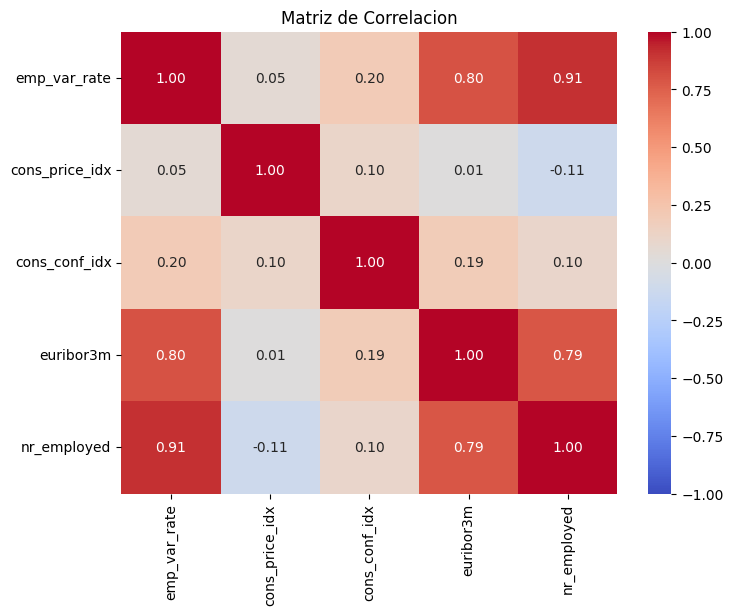

In [9]:
# Analisis de correlacion
Columnas_correlacion = [
    'emp_var_rate',
    'cons_price_idx',
    'cons_conf_idx',
    'euribor3m',
    'nr_employed'
]
datos_correlacion = df[Columnas_correlacion]
matriz_correlacion = datos_correlacion.corr()
# Impresion de grafico de correlacion
plt.figure(figsize=(8,6))
sns.heatmap(matriz_correlacion,annot=True,cmap='coolwarm',fmt='.2f',vmin=-1,vmax=1)
plt.title('Matriz de Correlacion')
plt.show()

*Resultado:* 
 - Los indices de correlacion entre euribor3m y nr_employed indican que la relacion interbancaria tiene un impacto en el mumero de la generacion de empleos con una correlacion de 0.79
 - Los indices de correlacion entre nr_employed y emp_var_rate presentan la correlacion mas fuertes en los datos, lo cual indica un impacto en la variacion de tasa de empleo con los empleos reportado en la region 
 

# Preprocesamiento y Normalizacion de los datos

- Normalizacion entre 0 y 1 = [Dias_Ultima_Camp,No_Contactos,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,Edad]
- one-hot encoding = [mora,Vivienda,Consumo,Resultado_Anterior,Tipo_Trabajo,Estado_Civil,Educacion,Contacto]

In [10]:
# Generar una copia de dataset 
df_original = df.copy()

In [11]:
# Definicion de variables
list_min_max = [
    'Dias_Ultima_Camp',
    'No_Contactos',
    'emp_var_rate',
    'cons_price_idx',
    'cons_conf_idx',
    'euribor3m',
    'nr_employed',
    'Edad'
]
list_get_dummies = [
    'mora',
    'Vivienda',
    'Consumo',
    'Mes',
    'Resultado_Anterior',
    'Tipo_Trabajo',
    'Estado_Civil',
    'Educacion',
    'Contacto'
]

In [12]:
# Normalizacion de Dataset en columnas especificadas en list_min_max
scaler = MinMaxScaler()
df[list_min_max] = scaler.fit_transform(df[list_min_max])

In [13]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# Generar columnas usando metodo one-hot encoding a columnas detalladas en list_get_dummies
df_matriz = pd.get_dummies(df,columns=list_get_dummies)
col_bool = df_matriz.iloc[:,-50:] 
df_matriz.iloc[:,-50:] = col_bool.astype(int)

In [14]:
# Defincion de variables (x) y (y)
X_matriz = df_matriz.drop(columns=['ID','y'],axis=1)
y_matriz = df_matriz['y']
# Generarar Matricez vectoriales
X = X_matriz.to_numpy()
y = y_matriz.to_numpy()